# Detection + Tracking + Anomaly Detection in Avenue, UCSD Datasets

### Importing required libraries

In [1]:
import os
import re
import cv2
import torch
import shutil
import random
import numpy as np
from glob import glob
from tqdm import tqdm
from scipy.io import loadmat
from natsort import natsorted
import matplotlib.pyplot as plt

### Mount google drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##  **Avenue Dataset for Abnormal Event Detection**


* This dataset accompanies paper "Abnormal Event Detection at 150 FPS in Matlab, Cewu Lu, Jianping Shi, Jiaya Jia, International Conference on Computer Vision, (ICCV), 2013"









```
Avenue Dataset
 └── testing_videos
 └── testing_vol
 └── training_videos
 └── training_vol
     
```

In [3]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 17516, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 17516 (delta 8), reused 0 (delta 0), pack-reused 17494 (from 3)
Receiving objects: 100% (17516/17516), 16.66 MiB | 18.80 MiB/s, done.
Resolving deltas: 100% (12000/12000), done.


In [4]:
%cd yolov5/
!pwd

/content/yolov5
/content/yolov5


In [5]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [6]:
%cd /content

/content


#### Using the pretrained YOLOv5m model

In [7]:
# Load custom YOLOv5m model
model = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained = True)

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-7-30 Python-3.11.13 torch-2.6.0+cu124 CPU

100%|██████████| 40.8M/40.8M [00:01<00:00, 29.0MB/s]

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
Adding AutoShape... 


In [8]:
! pip install deep_sort_realtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 12.3 MB/s eta 0:00:00


In [9]:
from deep_sort_realtime.deepsort_tracker import DeepSort

In [10]:
test_videos_folder = '/content/drive/MyDrive/Avenue_Dataset/test_videos'

In [11]:
output_video_folder = '/content/drive/MyDrive/Avenue_Output'
os.makedirs(output_video_folder, exist_ok = True)

In [12]:
anomaly_frames_folder = '/content/drive/MyDrive/Avenue_Output/Anomlay_frames'
os.makedirs(anomaly_frames_folder, exist_ok = True)

In [13]:
ground_truth_folder = '/content/drive/MyDrive/Avenue_Dataset/testing_label_mask'

In [14]:
def anomaly_detection(input_video_path=None, volLabel=None, output_video_path=None, output_frames_path=None):
  # Init DeepSORT tracker
  tracker = DeepSort(max_age = 30)

  # Input video
  cap = cv2.VideoCapture(input_video_path)

  # Get video info
  fps = cap.get(cv2.CAP_PROP_FPS)
  width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print(f"Video: {fps} FPS, {width}x{height}, {frame_count} frames")

  # Prepare output video writer
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  out    = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

  import warnings
  warnings.filterwarnings("ignore", category=FutureWarning)

  read_count = 0
  frame_idx = 0

  pbar = tqdm(total=frame_count)


  track_memory = {}           # Memory for tracking: store last N positions
  anomaly_memory1 = {}         # store last anomaly state (for smoothing) for anomaly1
  anomaly_memory2 = {}         # store last anomaly state (for smoothing) for anomaly2

  frame_anomaly = False

  tp_frame = 0
  tn_frame = 0
  fp_frame = 0
  fn_frame = 0

  tp_pixels = 0
  tn_pixels = 0
  fp_pixels = 0
  fn_pixels = 0

  saved_anomaly_ids = set()   # to avoid saving duplicates
  max_anomaly_frames = 500    # limit on the frames saved

  while cap.isOpened():

      ret, frame = cap.read()
      if not ret:
          break

      frame_anomaly = False

      # YOLO Inference
      results = model(frame)
      detections = results.xyxy[0].cpu().numpy()  # (xmin, ymin, xmax, ymax, conf, cls)

      allowed_classes = [0,1,2,3,5,7]             # person, bicycle, car, motorbike, bus, truck

      # Attach class info to each detection for later usage
      formatted_detections = []



      for d in detections:
          xmin, ymin, xmax, ymax, conf, cls = d
          if int(cls) in allowed_classes:
              width_box = xmax - xmin
              height_box = ymax - ymin
              box = [xmin, ymin, width_box, height_box]
              formatted_detections.append(([box, conf],int(cls)))


      formatted_detections_only = [fd[0] for fd in formatted_detections]
      class_ids_per_detection = [fd[1] for fd in formatted_detections]

      # Update tracker
      tracks = tracker.update_tracks(formatted_detections_only, frame=frame)

      # Draw tracks
      for track in tracks:

          if not track.is_confirmed():
              continue

          track_id = track.track_id       # unique ID assigned to the pedestrian
          ltrb     = track.to_ltrb()      # gives [left, top, right, bottom] of bounding box

          anomaly1 = False
          anomaly2 = False


  #-----------------------ANOMALY_1--------------------------

          xmin, ymin, xmax, ymax = map(int, ltrb)

          # Center point
          center_x = (xmin + xmax) / 2
          center_y = (ymin + ymax) / 2

          # Update history
          track_memory.setdefault(track_id, []).append((frame_idx, center_x, center_y))
          track_memory[track_id] = track_memory[track_id][-N_history:]

          # Calculate velocity
          if len(track_memory[track_id]) >= 2:
              f1, x1, y1 = track_memory[track_id][0]
              f2, x2, y2 = track_memory[track_id][-1]

              dt = (f2 - f1) / fps  # time in seconds
              dx = x2 - x1
              dy = y2 - y1
              distance = np.sqrt(dx**2 + dy**2)

              velocity = distance / (dt + 1e-6)  # avoid zero div

              # Anomaly flag
              if velocity > velocity_threshold:
                  anomaly1 = True
              else:
                  anomaly1 = False


  #-----------------------ANOMALY_2--------------------------

          # Approximate matching by IOU or center point
          matched_class = None

          for ([box, conf], cls) in formatted_detections:
            x1, y1, w, h = box
            x2 = x1 + w
            y2 = y1 + h

            # IOU-style overlap check
            iou_thresh = 0.5
            inter_x1 = max(x1, xmin)
            inter_y1 = max(y1, ymin)
            inter_x2 = min(x2, xmax)
            inter_y2 = min(y2, ymax)

            inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
            area_box = w * h
            area_track = (xmax - xmin) * (ymax - ymin)
            iou = inter_area / float(area_box + area_track - inter_area + 1e-6)

            if iou > iou_thresh:
                matched_class = cls
                break

          anomaly2 = matched_class in [1, 2, 3, 5, 7]

          if anomaly1 == True  :
            anomaly_memory1[track_id] = frame_idx  # mark when anomaly1 seen

          if anomaly2 == True  :
            anomaly_memory2[track_id] = frame_idx  # mark when anomaly2 seen

          if track_id in anomaly_memory1:
            if frame_idx - anomaly_memory1[track_id] <= smoothing_frames:
                anomaly1 = True  # force RED

          if track_id in anomaly_memory2:
            if frame_idx - anomaly_memory2[track_id] <= smoothing_frames:
                anomaly2 = True  # force RED

          if anomaly1 == True or anomaly2 == True:


            frame_anomaly = True

            label = f"ID {track_id} {'ANOMALY'}"
            cv2.rectangle(frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0,0,255), 1)
            cv2.putText(frame, label, (int(xmin), int(ymin) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)

            # Save anomaly frame if conditions met
            if len(saved_anomaly_ids) < max_anomaly_frames:
                # Create a unique filename
                filename = f"{output_frames_path}/frame_{frame_idx:05d}_id_{track_id}.jpg"
                cv2.imwrite(filename, frame)
                saved_anomaly_ids.add((frame_idx, track_id))

            # Pixel Level Comparison
            gt_mask = volLabel[frame_idx]
            pred_mask = np.zeros_like(gt_mask)

            xmin = max(0, int(xmin))
            ymin = max(0, int(ymin))
            xmax = min(width, int(xmax))
            ymax = min(height, int(ymax))


            pred_mask[int(ymin):int(ymax), int(xmin):int(xmax)] = 1

            tp_pixels += np.logical_and(pred_mask == 1, gt_mask == 1).sum()
            tn_pixels += np.logical_and(pred_mask == 0, gt_mask == 0).sum()
            fp_pixels += np.logical_and(pred_mask == 1, gt_mask == 0).sum()
            fn_pixels += np.logical_and(pred_mask == 0, gt_mask == 1).sum()


      # Frame Level Comparison
      gt_anomaly = np.sum(volLabel[frame_idx]) > 0

      if gt_anomaly and frame_anomaly:
        tp_frame +=1
      elif not gt_anomaly and not frame_anomaly:
        tn_frame +=1
      elif not gt_anomaly and frame_anomaly:
        fp_frame +=1
      elif gt_anomaly and not frame_anomaly:
        fn_frame +=1


      # Write frame
      out.write(frame)

      frame_idx += 1
      read_count += 1
      pbar.update(1)



  # Frame-Level
  frame_precision = tp_frame / (tp_frame + fp_frame + 1e-6)
  frame_recall = tp_frame / (tp_frame + fn_frame + 1e-6)
  frame_f1 = 2 * frame_precision * frame_recall / (frame_precision + frame_recall + 1e-6)


  # Pixel-Level
  pixel_precision = tp_pixels / (tp_pixels + fp_pixels + 1e-6)
  pixel_recall = tp_pixels / (tp_pixels + fn_pixels + 1e-6)
  pixel_f1 = 2 * pixel_precision * pixel_recall / (pixel_precision + pixel_recall + 1e-6)

  pbar.close()
  cap.release()
  out.release()

  print(f"\n Frames read: {read_count} / {frame_count}")
  print(f"\n DONE — output saved to: {output_video_path}")
  print(f""" Frame-Level:
              Precision: {frame_precision:.4f}
              Recall   : {frame_recall:.4f}
              F1_score : {frame_f1:.4f} """)

  print(f""" Pixel-Level:
              Precision: {pixel_precision:.4f}
              Recall   : {pixel_recall:.4f}
              F1_score : {pixel_f1:.4f} """)

In [38]:
N_history = 15             # how many frames to use for velocity calc
smoothing_frames = 5       # Smoothing: once RED, stay RED for N frames
velocity_threshold = 270   # Velocity threshold (pixels per second)

In [39]:
model.conf = 0.5
model.iou = 0.5

In [40]:
test_video = '16.avi'

In [41]:
input_video_path =  os.path.join(test_videos_folder,test_video)

In [42]:
# Extract only the numeric part
video_num = re.findall(r'\d+', test_video)[0]

In [43]:
output_video_path = os.path.join(output_video_folder,f'{video_num}_{N_history}_{smoothing_frames}_{velocity_threshold}.mp4')

In [44]:
output_frames_path = os.path.join(anomaly_frames_folder, f'{video_num}')
os.makedirs(output_frames_path,exist_ok=True)

In [45]:
if video_num[0] == '0' :
  num = video_num[1]
else:
  num = video_num

In [46]:
gt_path = os.path.join(ground_truth_folder,f'{num}_label.mat')
gt_data = loadmat(gt_path)

In [47]:
volLabel = gt_data['volLabel'] # shape: (1, N), each is a cell with (H, W) binary mask
volLabel = volLabel[0]  # unpack the cell array

In [ ]:
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1439 frames


100%|██████████| 1439/1439 [26:57<00:00,  1.12s/it]


 Frames read: 1439 / 1439

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/01_15_5_230.mp4
 Frame-Level:
              Precision: 0.4740
              Recall   : 0.2230
              F1_score : 0.3033 
 Pixel-Level:
              Precision: 0.5219
              Recall   : 0.6347
              F1_score : 0.5728 


In [ ]:
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1439 frames


100%|██████████| 1439/1439 [02:40<00:00,  8.97it/s]


 Frames read: 1439 / 1439

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/01_15_5_250.mp4
 Frame-Level:
              Precision: 0.5000
              Recall   : 0.1422
              F1_score : 0.2214 
 Pixel-Level:
              Precision: 0.8201
              Recall   : 0.5630
              F1_score : 0.6676 


In [ ]:
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1439 frames


100%|██████████| 1439/1439 [01:46<00:00, 13.47it/s]


 Frames read: 1439 / 1439

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/01_15_5_270.mp4
 Frame-Level:
              Precision: 0.4607
              Recall   : 0.1005
              F1_score : 0.1650 
 Pixel-Level:
              Precision: 0.8199
              Recall   : 0.5490
              F1_score : 0.6576 


---

In [ ]:
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1211 frames


100%|██████████| 1211/1211 [02:06<00:00,  9.60it/s]


 Frames read: 1211 / 1211

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/02_15_5_230.mp4
 Frame-Level:
              Precision: 0.3333
              Recall   : 0.6854
              F1_score : 0.4485 
 Pixel-Level:
              Precision: 0.1639
              Recall   : 0.1911
              F1_score : 0.1765 


In [ ]:
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1211 frames


100%|██████████| 1211/1211 [01:52<00:00, 10.79it/s]


 Frames read: 1211 / 1211

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/02_15_5_250.mp4
 Frame-Level:
              Precision: 0.3506
              Recall   : 0.6854
              F1_score : 0.4639 
 Pixel-Level:
              Precision: 0.1701
              Recall   : 0.1925
              F1_score : 0.1806 


In [ ]:
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 1211 frames


100%|██████████| 1211/1211 [01:52<00:00, 10.74it/s]


 Frames read: 1211 / 1211

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/02_15_5_270.mp4
 Frame-Level:
              Precision: 0.3310
              Recall   : 0.5393
              F1_score : 0.4103 
 Pixel-Level:
              Precision: 0.2408
              Recall   : 0.2476
              F1_score : 0.2442 


---

In [ ]:
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 923 frames


100%|██████████| 923/923 [01:23<00:00, 11.01it/s]


 Frames read: 923 / 923

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/03_15_5_230.mp4
 Frame-Level:
              Precision: 0.4237
              Recall   : 0.8621
              F1_score : 0.5682 
 Pixel-Level:
              Precision: 0.2545
              Recall   : 0.5032
              F1_score : 0.3381 


In [ ]:
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 923 frames


100%|██████████| 923/923 [01:12<00:00, 12.75it/s]


 Frames read: 923 / 923

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/03_15_5_250.mp4
 Frame-Level:
              Precision: 0.4479
              Recall   : 0.8391
              F1_score : 0.5840 
 Pixel-Level:
              Precision: 0.2598
              Recall   : 0.5354
              F1_score : 0.3498 


In [ ]:
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 923 frames


100%|██████████| 923/923 [01:10<00:00, 13.12it/s]


 Frames read: 923 / 923

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/03_15_5_270.mp4
 Frame-Level:
              Precision: 0.4238
              Recall   : 0.7356
              F1_score : 0.5378 
 Pixel-Level:
              Precision: 0.2609
              Recall   : 0.5968
              F1_score : 0.3631 


---

In [ ]:
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 947 frames


100%|██████████| 947/947 [01:16<00:00, 12.43it/s]


 Frames read: 947 / 947

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/04_15_5_230.mp4
 Frame-Level:
              Precision: 0.4699
              Recall   : 0.9247
              F1_score : 0.6232 
 Pixel-Level:
              Precision: 0.2829
              Recall   : 0.4894
              F1_score : 0.3585 


In [ ]:
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 947 frames


100%|██████████| 947/947 [01:13<00:00, 12.81it/s]


 Frames read: 947 / 947

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/04_15_5_250.mp4
 Frame-Level:
              Precision: 0.4696
              Recall   : 0.9140
              F1_score : 0.6204 
 Pixel-Level:
              Precision: 0.2812
              Recall   : 0.4876
              F1_score : 0.3567 


In [ ]:
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 947 frames


100%|██████████| 947/947 [01:15<00:00, 12.50it/s]


 Frames read: 947 / 947

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/04_15_5_270.mp4
 Frame-Level:
              Precision: 0.5155
              Recall   : 0.8925
              F1_score : 0.6535 
 Pixel-Level:
              Precision: 0.2811
              Recall   : 0.4877
              F1_score : 0.3566 


---

In [ ]:
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 740 frames


100%|██████████| 740/740 [01:00<00:00, 12.26it/s]


 Frames read: 740 / 740

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/16_15_5_230.mp4
 Frame-Level:
              Precision: 0.4844
              Recall   : 1.0000
              F1_score : 0.6527 
 Pixel-Level:
              Precision: 0.3926
              Recall   : 0.2390
              F1_score : 0.2971 


In [37]:
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 740 frames


100%|██████████| 740/740 [13:27<00:00,  1.09s/it]


 Frames read: 740 / 740

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/16_15_5_250.mp4
 Frame-Level:
              Precision: 0.5142
              Recall   : 1.0000
              F1_score : 0.6791 
 Pixel-Level:
              Precision: 0.4088
              Recall   : 0.2390
              F1_score : 0.3016 


In [48]:
anomaly_detection(input_video_path, volLabel, output_video_path, output_frames_path)

Video: 25.0 FPS, 640x360, 740 frames


100%|██████████| 740/740 [13:17<00:00,  1.08s/it]


 Frames read: 740 / 740

 DONE — output saved to: /content/drive/MyDrive/Avenue_Output/16_15_5_270.mp4
 Frame-Level:
              Precision: 0.5142
              Recall   : 1.0000
              F1_score : 0.6791 
 Pixel-Level:
              Precision: 0.4088
              Recall   : 0.2390
              F1_score : 0.3016 


# RESULTS
* In this project simple rule based logic is used for anomlay detection
* Since the logic for anomaly detection targets some anomalies and not all, **precision** is an appropriate metric in this case to compare against the groud truth.
* Precision is calculated for each test video at both frame-level and pixel-level
* The precision values for all 5 test videos are averaged to get avg precision  

#### Parameter values:

* N_history = 20 (how many frames to use for velocity calc)

* smoothing_frames = 5 (Smoothing: once RED, stay RED for N frames)

* velocity_threshold = 270 (Velocity threshold (pixels per second))

### Average frame level precision = 0.4565
### Average pixel level precision = 0.3880


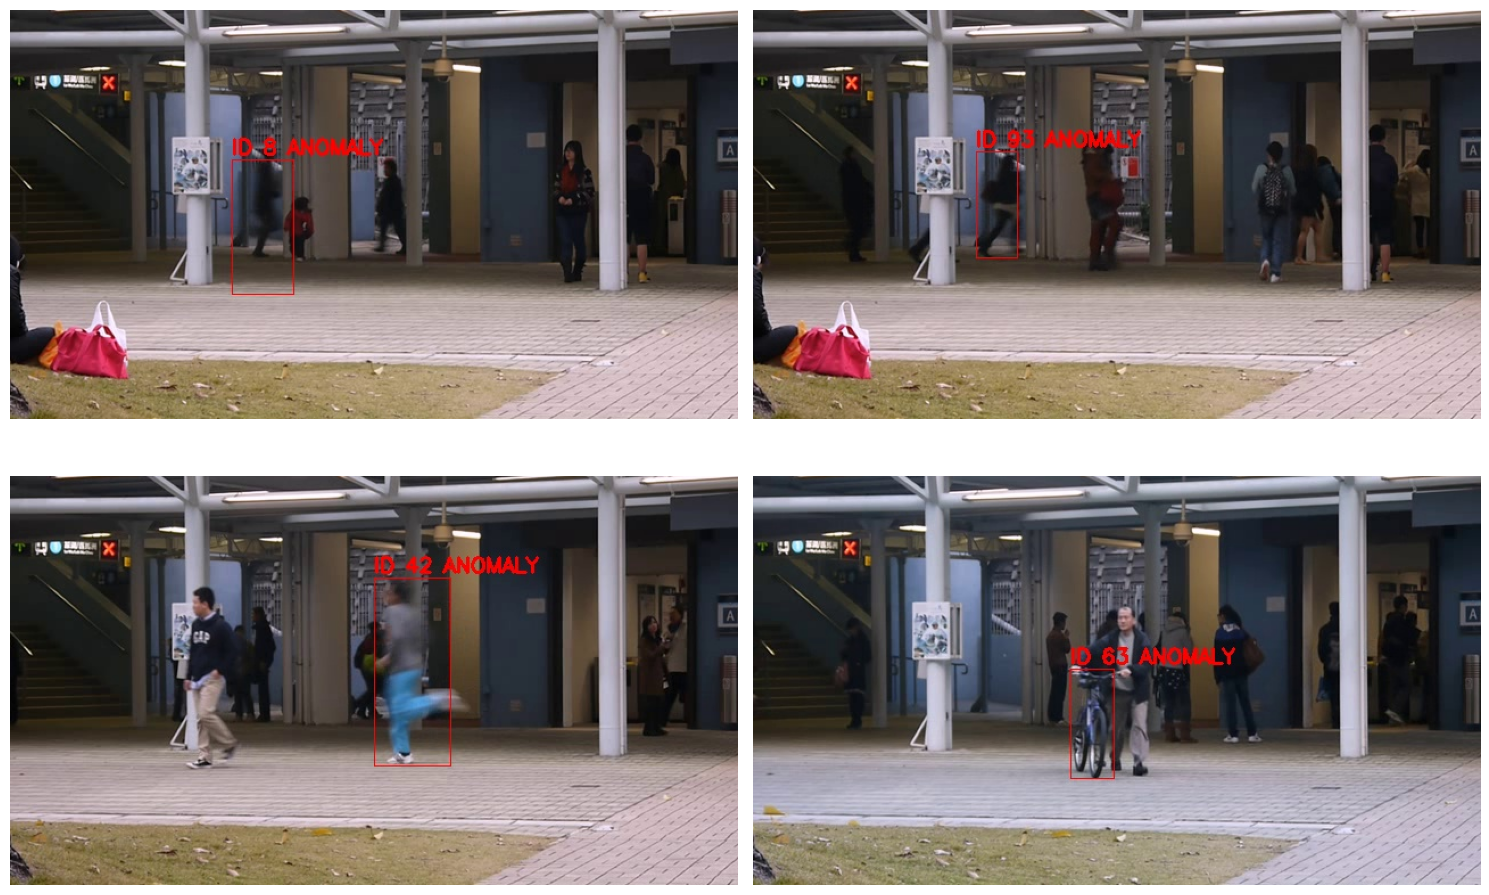

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Load images
img1 = cv2.imread('/content/frame_00097_id_8.jpg')
img2 = cv2.imread('/content/frame_01325_id_93.jpg')
img3 = cv2.imread('/content/frame_00398_id_42.jpg')
img4 = cv2.imread('/content/frame_00703_id_63.jpg')


# Convert BGR to RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.imshow(img1)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(img2)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(img3)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(img4)
plt.axis('off')

plt.tight_layout()
plt.show()

---
---
# UCSD_DATASET

UCSD Anomaly Detection Dataset (Ped1 & Ped2)

Citation:

Anomaly Detection in Crowded Scenes.

V. Mahadevan, W. Li, V. Bhalodia and N. Vasconcelos.

In Proc. IEEE Conference on Computer Vision and Pattern Recognition (CVPR), San Francisco, CA, 2010

In [ ]:
# Root folder containing subfolders of frames
root_dir = '/content/drive/MyDrive/UCSD_Anomaly_Dataset/UCSD_Ped2_JPEGs_folder_wise'
output_dir = '/content/drive/MyDrive/UCSD_Anomaly_Dataset/Ped2_videos'
os.makedirs(output_dir,exist_ok=True)
fps = 25

# Loop through each subfolder
for subfolder in sorted(os.listdir(root_dir)):
    subfolder_path = os.path.join(root_dir, subfolder)
    if not os.path.isdir(subfolder_path):
        continue  # Skip non-folders

    # Get sorted list of image frames
    frame_files = [f for f in os.listdir(subfolder_path) if f.endswith('.jpg')]
    frame_files = natsorted(frame_files)

    if not frame_files:
        print(f" No frames found in {subfolder}")
        continue

    # Read first frame to get dimensions
    first_frame = cv2.imread(os.path.join(subfolder_path, frame_files[0]))
    height, width, _ = first_frame.shape

    # Define output video path
    output_path = os.path.join(output_dir, f"{subfolder}.mp4")

    # Set up video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    print(f" Creating video for {subfolder} ...")

    for file in frame_files:
        frame_path = os.path.join(subfolder_path, file)
        frame = cv2.imread(frame_path)
        if frame is not None:
            out.write(frame)

    out.release()
    print(f" Saved: {output_path}")

 Creating video for Test001 ...
 Saved: /content/drive/MyDrive/UCSD_Anomaly_Dataset/Ped2_videos/Test001.mp4
 Creating video for Test002 ...
 Saved: /content/drive/MyDrive/UCSD_Anomaly_Dataset/Ped2_videos/Test002.mp4
 Creating video for Test003 ...
 Saved: /content/drive/MyDrive/UCSD_Anomaly_Dataset/Ped2_videos/Test003.mp4
 Creating video for Test004 ...
 Saved: /content/drive/MyDrive/UCSD_Anomaly_Dataset/Ped2_videos/Test004.mp4
 Creating video for Test005 ...
 Saved: /content/drive/MyDrive/UCSD_Anomaly_Dataset/Ped2_videos/Test005.mp4
 Creating video for Test006 ...
 Saved: /content/drive/MyDrive/UCSD_Anomaly_Dataset/Ped2_videos/Test006.mp4
 Creating video for Test007 ...
 Saved: /content/drive/MyDrive/UCSD_Anomaly_Dataset/Ped2_videos/Test007.mp4
 Creating video for Test008 ...
 Saved: /content/drive/MyDrive/UCSD_Anomaly_Dataset/Ped2_videos/Test008.mp4
 Creating video for Test009 ...
 Saved: /content/drive/MyDrive/UCSD_Anomaly_Dataset/Ped2_videos/Test009.mp4
 Creating video for Test010 

In [ ]:
def load_ground_truth_masks(gt_folder_path, frame_count, target_size):
    gt_masks = []
    for i in range(1, frame_count + 1):
        bmp_path = os.path.join(gt_folder_path, f"{i:03d}.bmp")
        if os.path.exists(bmp_path):
            mask = cv2.imread(bmp_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, target_size[::-1])  # cv2 expects (W, H)
            mask = (mask > 127).astype(np.uint8)  # binarize
        else:
            mask = np.zeros(target_size, dtype=np.uint8)  # assume normal if no file
        gt_masks.append(mask)
    return gt_masks

In [ ]:
gt_folder = '/content/drive/MyDrive/UCSD_Anomaly_Dataset/UCSDped2/Test'

In [ ]:
test_videos_folder = '/content/drive/MyDrive/UCSD_Anomaly_Dataset/Ped2_videos'

In [ ]:
test_video = 'Test007.mp4'

In [ ]:
gt_masks_folder = '/content/drive/MyDrive/UCSD_Anomaly_Dataset/Test_gt_masks'
os.makedirs(gt_masks_folder, exist_ok = True)

In [ ]:
for i in range(1,13):

  gt_folder_path = os.path.join(gt_folder,f'Test{i:03d}_gt')
  video_path =  os.path.join(test_videos_folder, f'Test{i:03d}.mp4')

  # Input video
  cap = cv2.VideoCapture(video_path)

  # Get video info
  width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  cap.release()

  gt_masks = load_ground_truth_masks(gt_folder_path, frame_count, target_size=(height,width))
  np.save(os.path.join(gt_masks_folder, f'Test{i:03d}_gt.npy'), np.array(gt_masks, dtype=np.uint8))
  print(f"gt_mask saved for Test{i:03d}.mp4")

gt_mask saved for Test001.mp4
gt_mask saved for Test002.mp4
gt_mask saved for Test003.mp4
gt_mask saved for Test004.mp4
gt_mask saved for Test005.mp4
gt_mask saved for Test006.mp4
gt_mask saved for Test007.mp4
gt_mask saved for Test008.mp4
gt_mask saved for Test009.mp4
gt_mask saved for Test010.mp4
gt_mask saved for Test011.mp4
gt_mask saved for Test012.mp4


In [ ]:
def load_ground_truth_masks_6_9_12(gt_folder_path, frame_count, target_size):
    gt_masks = []
    for i in range(1, frame_count + 1):
        bmp_path = os.path.join(gt_folder_path, f"frame{i:03d}.bmp")
        if os.path.exists(bmp_path):
            mask = cv2.imread(bmp_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, target_size[::-1])  # cv2 expects (W, H)
            mask = (mask > 127).astype(np.uint8)  # binarize
        else:
            mask = np.zeros(target_size, dtype=np.uint8)  # assume normal if no file
        gt_masks.append(mask)
    return gt_masks

In [ ]:
i = 12

In [ ]:
diff_notation_videos = [6,9,12]

In [ ]:
for i in diff_notation_videos:
  gt_folder_path = os.path.join(gt_folder,f'Test{i:03d}_gt')
  video_path =  os.path.join(test_videos_folder, f'Test{i:03d}.mp4')

  # Input video
  cap = cv2.VideoCapture(video_path)

  # Get video info
  width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  cap.release()

  gt_masks = load_ground_truth_masks_6_9_12(gt_folder_path, frame_count, target_size=(height,width))
  np.save(os.path.join(gt_masks_folder, f'Test{i:03d}_gt.npy'), np.array(gt_masks, dtype=np.uint8))
  print(f"gt_mask saved for Test{i:03d}.mp4")

gt_mask saved for Test006.mp4
gt_mask saved for Test009.mp4
gt_mask saved for Test012.mp4


In [ ]:
gt_folder_path = os.path.join(gt_folder,f'Test{i:03d}_gt')
video_path =  os.path.join(test_videos_folder, f'Test{i:03d}.mp4')

# Input video
cap = cv2.VideoCapture(video_path)

# Get video info
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

gt_masks = load_ground_truth_masks_6_9_12(gt_folder_path, frame_count, target_size=(height,width))
np.save(os.path.join(gt_masks_folder, f'Test{i:03d}_gt.npy'), np.array(gt_masks, dtype=np.uint8))
print(f"gt_mask saved for Test{i:03d}.mp4")

gt_mask saved for Test012.mp4


In [ ]:
def anomaly_detection_ucsd(input_video_path=None, output_video_path=None, output_frames_path=None, gt_masks=None):
  # Init DeepSORT tracker
  tracker = DeepSort(max_age = 30)

  # Input video
  cap = cv2.VideoCapture(input_video_path)

  # Get video info
  fps = cap.get(cv2.CAP_PROP_FPS)
  width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  print(f"Video: {fps} FPS, {width}x{height}, {frame_count} frames")

  # Prepare output video writer
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  out    = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

  import warnings
  warnings.filterwarnings("ignore", category=FutureWarning)

  read_count = 0
  frame_idx = 0

  pbar = tqdm(total=frame_count)


  track_memory = {}           # Memory for tracking: store last N positions
  anomaly_memory1 = {}         # store last anomaly state (for smoothing) for anomaly1
  anomaly_memory2 = {}         # store last anomaly state (for smoothing) for anomaly2

  frame_anomaly = False

  tp_frame = 0
  tn_frame = 0
  fp_frame = 0
  fn_frame = 0

  tp_pixels = 0
  tn_pixels = 0
  fp_pixels = 0
  fn_pixels = 0

  saved_anomaly_ids = set()   # to avoid saving duplicates
  max_anomaly_frames = 200    # limit on the frames saved


  while cap.isOpened():

      ret, frame = cap.read()
      if not ret:
          break

      frame_anomaly = False

      # YOLO Inference
      results = model(frame)
      detections = results.xyxy[0].cpu().numpy()  # (xmin, ymin, xmax, ymax, conf, cls)

      allowed_classes = [0,1,2,3,5,7]             # person, bicycle, car, motorbike, bus, truck, skateboard

      # Attach class info to each detection for later usage
      formatted_detections = []

      for d in detections:
          xmin, ymin, xmax, ymax, conf, cls = d
          if int(cls) in allowed_classes:
              width_box = xmax - xmin
              height_box = ymax - ymin
              box = [xmin, ymin, width_box, height_box]
              formatted_detections.append(([box, conf],int(cls)))


      formatted_detections_only = [fd[0] for fd in formatted_detections]
      class_ids_per_detection = [fd[1] for fd in formatted_detections]

      # Update tracker
      tracks = tracker.update_tracks(formatted_detections_only, frame=frame)

      # Draw tracks
      for track in tracks:

          if not track.is_confirmed():
              continue

          track_id = track.track_id       # unique ID assigned to the pedestrian
          ltrb     = track.to_ltrb()      # gives [left, top, right, bottom] of bounding box

          anomaly1 = False
          anomaly2 = False


  #-----------------------ANOMALY_1--------------------------

          xmin, ymin, xmax, ymax = map(int, ltrb)

          # Center point
          center_x = (xmin + xmax) / 2
          center_y = (ymin + ymax) / 2

          # Update history
          track_memory.setdefault(track_id, []).append((frame_idx, center_x, center_y))
          track_memory[track_id] = track_memory[track_id][-N_history:]

          # Calculate velocity
          if len(track_memory[track_id]) >= 2:
              f1, x1, y1 = track_memory[track_id][0]
              f2, x2, y2 = track_memory[track_id][-1]

              dt = (f2 - f1) / fps  # time in seconds
              dx = x2 - x1
              dy = y2 - y1
              distance = np.sqrt(dx**2 + dy**2)

              velocity = distance / (dt + 1e-6)  # avoid zero div

              # Anomaly flag
              if velocity > velocity_threshold:
                  anomaly1 = True
              else:
                  anomaly1 = False


  #-----------------------ANOMALY_2--------------------------

          # Approximate matching by IOU or center point
          matched_class = None

          for ([box, conf], cls) in formatted_detections:
            x1, y1, w, h = box
            x2 = x1 + w
            y2 = y1 + h

            # IOU-style overlap check
            iou_thresh = 0.5
            inter_x1 = max(x1, xmin)
            inter_y1 = max(y1, ymin)
            inter_x2 = min(x2, xmax)
            inter_y2 = min(y2, ymax)

            inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
            area_box = w * h
            area_track = (xmax - xmin) * (ymax - ymin)
            iou = inter_area / float(area_box + area_track - inter_area + 1e-6)

            if iou > iou_thresh:
                matched_class = cls
                break

          anomaly2 = matched_class in [1, 2, 3, 5, 7]

          if anomaly1 == True  :
            anomaly_memory1[track_id] = frame_idx  # mark when anomaly1 seen

          if anomaly2 == True  :
            anomaly_memory2[track_id] = frame_idx  # mark when anomaly2 seen

          if track_id in anomaly_memory1:
            if frame_idx - anomaly_memory1[track_id] <= smoothing_frames:
                anomaly1 = True  # force RED

          if track_id in anomaly_memory2:
            if frame_idx - anomaly_memory2[track_id] <= smoothing_frames:
                anomaly2 = True  # force RED



          if anomaly1 == True or anomaly2 == True:

            frame_anomaly = True

            label = f"ID {track_id} {'ANOMALY'}"
            cv2.rectangle(frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0,0,255), 1)
            cv2.putText(frame, label, (int(xmin), int(ymin) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1)

            # Save anomaly frame if conditions met
            if len(saved_anomaly_ids) < max_anomaly_frames:
                # Create a unique filename
                filename = f"{output_frames_path}/frame_{frame_idx:05d}_id_{track_id}.jpg"
                cv2.imwrite(filename, frame)
                saved_anomaly_ids.add((frame_idx, track_id))

            # Pixel Level Comparison
            gt_mask = gt_masks[frame_idx]
            pred_mask = np.zeros_like(gt_mask)

            xmin = max(0, int(xmin))
            ymin = max(0, int(ymin))
            xmax = min(width, int(xmax))
            ymax = min(height, int(ymax))


            pred_mask[int(ymin):int(ymax), int(xmin):int(xmax)] = 1

            tp_pixels += np.logical_and(pred_mask == 1, gt_mask == 1).sum()
            tn_pixels += np.logical_and(pred_mask == 0, gt_mask == 0).sum()
            fp_pixels += np.logical_and(pred_mask == 1, gt_mask == 0).sum()
            fn_pixels += np.logical_and(pred_mask == 0, gt_mask == 1).sum()

      # Frame Level Comparison
      gt_anomaly = np.sum(gt_masks[frame_idx]) > 0

      if gt_anomaly and frame_anomaly:
        tp_frame +=1
      elif not gt_anomaly and not frame_anomaly:
        tn_frame +=1
      elif not gt_anomaly and frame_anomaly:
        fp_frame +=1
      elif gt_anomaly and not frame_anomaly:
        fn_frame +=1


      # Write frame
      out.write(frame)

      frame_idx += 1
      read_count += 1
      pbar.update(1)



  # Frame-Level
  frame_precision = tp_frame / (tp_frame + fp_frame + 1e-6)
  frame_recall = tp_frame / (tp_frame + fn_frame + 1e-6)
  frame_f1 = 2 * frame_precision * frame_recall / (frame_precision + frame_recall + 1e-6)


  # Pixel-Level
  pixel_precision = tp_pixels / (tp_pixels + fp_pixels + 1e-6)
  pixel_recall = tp_pixels / (tp_pixels + fn_pixels + 1e-6)
  pixel_f1 = 2 * pixel_precision * pixel_recall / (pixel_precision + pixel_recall + 1e-6)

  pbar.close()
  cap.release()
  out.release()

  print(f"\n Frames read: {read_count} / {frame_count}")
  print(f"\n DONE — output saved to: {output_video_path}")
  print(f""" Frame-Level:
              Precision: {frame_precision:.4f}
              Recall   : {frame_recall:.4f}
              F1_score : {frame_f1:.4f} """)

  print(f""" Pixel-Level:
              Precision: {pixel_precision:.4f}
              Recall   : {pixel_recall:.4f}
              F1_score : {pixel_f1:.4f} """)

In [ ]:
test_videos_folder = '/content/drive/MyDrive/UCSD_Anomaly_Dataset/Ped2_videos'

In [ ]:
op_video_folder = '/content/drive/MyDrive/UCSD_output'
os.makedirs(op_video_folder, exist_ok = True)

In [ ]:
anomaly_frames_dir ='/content/drive/MyDrive/UCSD_output/Anomaly_frames'
os.makedirs(anomaly_frames_dir, exist_ok = True)

In [ ]:
N_history = 10             # how many frames to use for velocity calc
smoothing_frames = 5     # Smoothing: once RED, stay RED for N frames
velocity_threshold = 230   # Velocity threshold (pixels per second)

In [ ]:
model.conf = 0.5
model.iou = 0.5

In [ ]:
test_video = 'Test012.mp4'

In [ ]:
ip_video_path =  os.path.join(test_videos_folder ,test_video)

In [ ]:
# Extract only the numeric part
video_number = re.findall(r'\d+', test_video)[0]

In [ ]:
video_number

'012'

In [ ]:
op_video_path = os.path.join(op_video_folder,f'{video_number}_{N_history}_{smoothing_frames}_{velocity_threshold}.mp4')

In [ ]:
op_frames_path = os.path.join(anomaly_frames_dir, f'{video_number}')
os.makedirs(op_frames_path,exist_ok=True)

In [ ]:
gt_folder = '/content/drive/MyDrive/UCSD_Anomaly_Dataset/UCSDped2/Test'

In [ ]:
gt_folder_path = os.path.join(gt_folder,f'Test{video_number}_gt')

In [ ]:
gt_masks_folder = '/content/drive/MyDrive/UCSD_Anomaly_Dataset/Test_gt_masks'
os.makedirs(gt_masks_folder, exist_ok = True)

In [ ]:
gt_masks = np.load(os.path.join(gt_masks_folder, f'Test{video_number}_gt.npy'))

In [ ]:
gt_masks.shape

(180, 240, 360)

In [ ]:
anomaly_detection_ucsd(ip_video_path, op_video_path, op_frames_path, gt_masks)

Video: 25.0 FPS, 360x240, 180 frames


100%|██████████| 180/180 [00:16<00:00, 11.06it/s]


 Frames read: 180 / 180

 DONE — output saved to: /content/drive/MyDrive/UCSD_output/001_10_5_230.mp4
 Frame-Level:
              Precision: 1.0000
              Recall   : 0.7583
              F1_score : 0.8626 
 Pixel-Level:
              Precision: 0.8674
              Recall   : 0.6212
              F1_score : 0.7239 


In [ ]:
anomaly_detection_ucsd(ip_video_path, op_video_path, op_frames_path, gt_masks)

Video: 25.0 FPS, 360x240, 180 frames


100%|██████████| 180/180 [00:15<00:00, 11.83it/s]


 Frames read: 180 / 180

 DONE — output saved to: /content/drive/MyDrive/UCSD_output/002_10_5_230.mp4
 Frame-Level:
              Precision: 1.0000
              Recall   : 0.9884
              F1_score : 0.9942 
 Pixel-Level:
              Precision: 0.7858
              Recall   : 0.7768
              F1_score : 0.7813 


In [ ]:
anomaly_detection_ucsd(ip_video_path, op_video_path, op_frames_path, gt_masks)

Video: 25.0 FPS, 360x240, 150 frames


100%|██████████| 150/150 [00:22<00:00,  6.79it/s]


 Frames read: 150 / 150

 DONE — output saved to: /content/drive/MyDrive/UCSD_output/003_10_5_230.mp4
 Frame-Level:
              Precision: 1.0000
              Recall   : 0.8699
              F1_score : 0.9304 
 Pixel-Level:
              Precision: 0.8053
              Recall   : 0.3707
              F1_score : 0.5077 


In [ ]:
anomaly_detection_ucsd(ip_video_path, op_video_path, op_frames_path, gt_masks)

Video: 25.0 FPS, 360x240, 180 frames


100%|██████████| 180/180 [00:19<00:00,  9.44it/s]


 Frames read: 180 / 180

 DONE — output saved to: /content/drive/MyDrive/UCSD_output/004_10_5_230.mp4
 Frame-Level:
              Precision: 1.0000
              Recall   : 0.9267
              F1_score : 0.9619 
 Pixel-Level:
              Precision: 0.8198
              Recall   : 0.6598
              F1_score : 0.7312 


In [ ]:
anomaly_detection_ucsd(ip_video_path, op_video_path, op_frames_path, gt_masks)

Video: 25.0 FPS, 360x240, 150 frames


100%|██████████| 150/150 [00:11<00:00, 13.01it/s]


 Frames read: 150 / 150

 DONE — output saved to: /content/drive/MyDrive/UCSD_output/005_10_5_230.mp4
 Frame-Level:
              Precision: 1.0000
              Recall   : 0.9612
              F1_score : 0.9802 
 Pixel-Level:
              Precision: 0.9223
              Recall   : 0.6970
              F1_score : 0.7940 


In [ ]:
anomaly_detection_ucsd(ip_video_path, op_video_path, op_frames_path, gt_masks)

Video: 25.0 FPS, 360x240, 180 frames


100%|██████████| 180/180 [00:18<00:00,  9.92it/s]


 Frames read: 180 / 180

 DONE — output saved to: /content/drive/MyDrive/UCSD_output/006_10_5_230.mp4
 Frame-Level:
              Precision: 1.0000
              Recall   : 0.9057
              F1_score : 0.9505 
 Pixel-Level:
              Precision: 0.7294
              Recall   : 0.4565
              F1_score : 0.5615 


In [ ]:
anomaly_detection_ucsd(ip_video_path, op_video_path, op_frames_path, gt_masks)

Video: 25.0 FPS, 360x240, 180 frames


100%|██████████| 180/180 [03:56<00:00,  1.31s/it]


 Frames read: 180 / 180

 DONE — output saved to: /content/drive/MyDrive/UCSD_output/007_10_5_230.mp4
 Frame-Level:
              Precision: 0.9060
              Recall   : 1.0000
              F1_score : 0.9507 
 Pixel-Level:
              Precision: 0.4012
              Recall   : 0.2183
              F1_score : 0.2827 


In [ ]:
anomaly_detection_ucsd(ip_video_path, op_video_path, op_frames_path, gt_masks)

Video: 25.0 FPS, 360x240, 180 frames


100%|██████████| 180/180 [00:17<00:00, 10.25it/s]


 Frames read: 180 / 180

 DONE — output saved to: /content/drive/MyDrive/UCSD_output/008_10_5_230.mp4
 Frame-Level:
              Precision: 1.0000
              Recall   : 0.9389
              F1_score : 0.9685 
 Pixel-Level:
              Precision: 0.9051
              Recall   : 0.4394
              F1_score : 0.5916 


In [ ]:
anomaly_detection_ucsd(ip_video_path, op_video_path, op_frames_path, gt_masks)

Video: 25.0 FPS, 360x240, 120 frames


100%|██████████| 120/120 [00:14<00:00,  8.36it/s]


 Frames read: 120 / 120

 DONE — output saved to: /content/drive/MyDrive/UCSD_output/009_10_5_230.mp4
 Frame-Level:
              Precision: 1.0000
              Recall   : 0.8833
              F1_score : 0.9381 
 Pixel-Level:
              Precision: 0.7124
              Recall   : 0.5553
              F1_score : 0.6241 


In [ ]:
anomaly_detection_ucsd(ip_video_path, op_video_path, op_frames_path, gt_masks)

Video: 25.0 FPS, 360x240, 150 frames


100%|██████████| 150/150 [00:10<00:00, 13.94it/s]


 Frames read: 150 / 150

 DONE — output saved to: /content/drive/MyDrive/UCSD_output/010_10_5_230.mp4
 Frame-Level:
              Precision: 1.0000
              Recall   : 0.9867
              F1_score : 0.9933 
 Pixel-Level:
              Precision: 0.9007
              Recall   : 0.7169
              F1_score : 0.7984 


In [ ]:
anomaly_detection_ucsd(ip_video_path, op_video_path, op_frames_path, gt_masks)

Video: 25.0 FPS, 360x240, 180 frames


100%|██████████| 180/180 [00:14<00:00, 12.31it/s]


 Frames read: 180 / 180

 DONE — output saved to: /content/drive/MyDrive/UCSD_output/011_10_5_230.mp4
 Frame-Level:
              Precision: 1.0000
              Recall   : 0.1611
              F1_score : 0.2775 
 Pixel-Level:
              Precision: 0.6462
              Recall   : 0.3264
              F1_score : 0.4337 


# RESULTS
* In this project simple rule based logic is used for anomlay detection
* Since the logic for anomaly detection targets some anomalies and not all, **precision** is an appropriate metric in this case to compare against the groud truth.
* Precision is calculated for each test video at both frame-level and pixel-level
* The precision values for all 11 test videos are averaged to get avg precision  

#### Parameter values:

* N_history = 10 (how many frames to use for velocity calc)

* smoothing_frames = 5 (Smoothing: once RED, stay RED for N frames)

* velocity_threshold = 230 (Velocity threshold (pixels per second))

### Average frame level precision = 0.9914
### Average pixel level precision = 0.7723


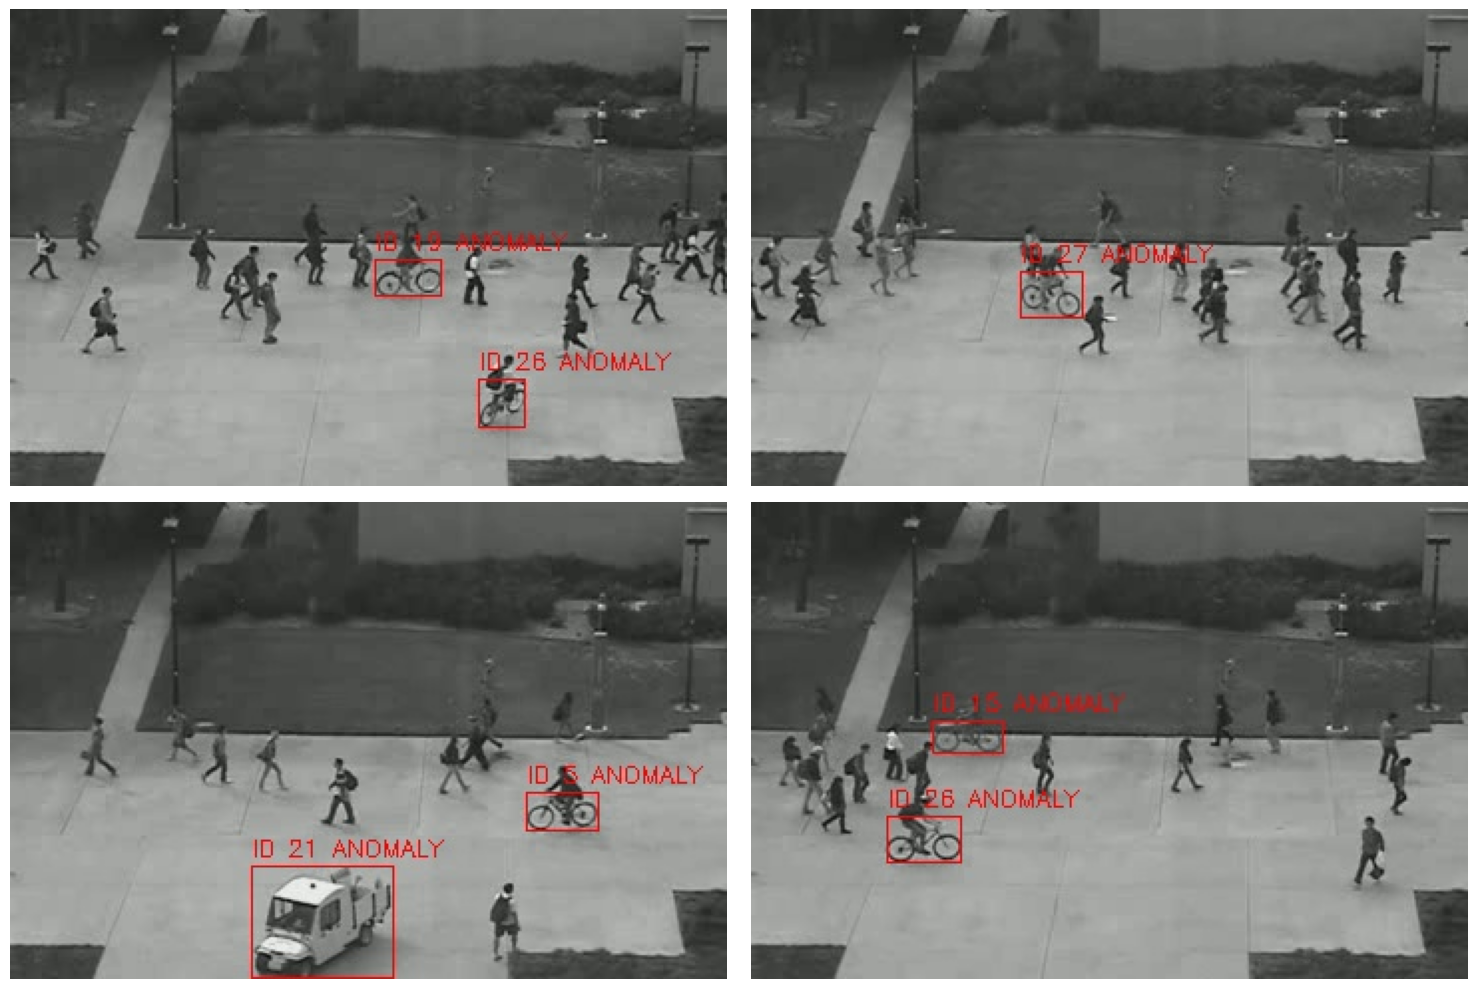

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Load images
img1 = cv2.imread('/content/frame_00060_id_26.jpg')
img2 = cv2.imread('/content/frame_00130_id_27.jpg')
img3 = cv2.imread('/content/frame_00157_id_21.jpg')
img4 = cv2.imread('/content/frame_00061_id_26.jpg')



# Convert BGR to RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.imshow(img1)
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(img2)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(img3)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(img4)
plt.axis('off')

plt.tight_layout()
plt.show()

---
---